# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# load the training, development and test sets 
training = pd.read_csv('data_sentiment/train.csv',header=-1)
development = pd.read_csv('data_sentiment/dev.csv',header=-1)
test_sets = pd.read_csv('data_sentiment/test.csv',header=-1)

If you use Pandas you can see a sample of the data.

The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [84]:
# put the raw texts into Python lists
train_list=training.values.tolist()
development_list=development.values.tolist()
test_sets_list=test_sets.values.tolist()

In [85]:
#Disorder

random.shuffle(train_list)
random.shuffle(development_list)

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [2]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [3]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    a=re.findall(token_pattern,x_raw)
    resultlist=[]
    b=[]
    #remove stoplist
    for i in a:
        if i not in stop_words:
            b.append(i)
    
    for i in b:
        resultlist.append(i)
    
   
    if ngram_range==(1,2):
        i=0
        for i in range(0,len(b)-1):
            tuble=(b[i],b[i+1])
            resultlist.append(tuble)
            
    if ngram_range==(1,3):
        i=0
        for i in range(0,len(b)-1):
            tuble=(b[i],b[i+1])
            
            resultlist.append(tuble)  
        j=0
        for j in range(0,len(b)-2):
            tuble=(b[j],b[j+1],b[j+2])
            resultlist.append(tuble)
    if vocab==set():    
        return resultlist  
    else:
        resultlist2=[]
        for i in resultlist:
            if i in vocab:
                resultlist2.append(i)
        return resultlist2



In [4]:

extract_ngrams("this is a great movie to watch ", 
               ngram_range=(1,3), 
               stop_words=stop_words)

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [5]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    
    
    # fill in your code...
    #Calculate NGram in all files，No repetitive NGram removed
    all_ngrams=[]
    ngrams_list=[]
    for s in X_raw:
        ngrams_one=extract_ngrams(s, ngram_range=ngram_range,stop_words=stop_words)
        all_ngrams.extend(ngrams_one)
        ngrams_list.append(ngrams_one)
    
    



    #get  ngram_counts
    Counter_ngrams=Counter(all_ngrams) #Total frequency of each NGram
    ngram_counts=Counter_ngrams.most_common(keep_topN)   
    #gey  vocab
    vocab=[]
    for i in range (0,keep_topN):
        vocab.append(ngram_counts[i][0])
        
    #  Disorganize vocab
    vocab=list(set(vocab))
        
        

    df={}
    for i in vocab:
        count=min_df
        
        for j in range(0,len(ngrams_list)):#  Loop through all files
            
            if i in ngrams_list[j]:     #If there is NGram in this file
                count=count+1
        df[i]=count
        
        
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [ ]:


def get_rawX(data):
    rawlist=[]
    for i in range(0,len(data)):
        rawlist.append(data[i][0])
        #print(data[i][0])
    return rawlist#  a list of strings each corresponding to the raw text of a document

In [ ]:
train_list_ngram=[]
for i in range(0,len(train_list)): 
    a=extract_ngrams(train_list[i][0], ngram_range=(1,3), stop_words=stop_words)
    train_list_ngram.append(a)

In [ ]:
X_tr_raw=get_rawX(train_list)
vocab_train, df_train, ngram_counts_train = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [ ]:
# vocabulary id -> word and id -> word

vocabulary={}
t=0
for w in vocab_train:
    vocabulary[t]=w
    t=t+1

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [91]:
# fill in your code...
train_list_ngram=[]
for i in range(0,len(train_list)): 
    a=extract_ngrams(train_list[i][0], ngram_range=(1,3), stop_words=stop_words)
    train_list_ngram.append(a)
development_ngram=[]
for i in range(0,len(development_list)): 
    a=extract_ngrams(development_list[i][0], ngram_range=(1,3), stop_words=stop_words)
    development_ngram.append(a)
test_ngram=[]
for i in range(0,len(test_sets_list)): 
    a=extract_ngrams(test_sets_list[i][0], ngram_range=(1,3), stop_words=stop_words)
    test_ngram.append(a)    

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [50]:
def vectorise(X_ngram, vocab):
    X_vec_list=[]
    for i in range(0,len(X_ngram)):  #Loop through each file
        a=[]
        c = Counter(X_ngram[i])
       # print(i)
       
        for j in range(0,len(vocab)):  #Cycle through each word
            
            if vocab[j] in X_ngram[i]:
                a.append(c[vocab[j]])
            else:
                
                a.append(0) 
            
        X_vec_list.append(a)
        
        
    X_vec=np.asarray(X_vec_list)
    

    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [87]:
# use vectorise to obtain document vectors for each document in the train, development and test set. 
def get_rawX(data):
    rawlist=[]
    for i in range(0,len(data)):
        rawlist.append(data[i][0])
    return rawlist#  a list of strings each corresponding to the raw text of a document

In [88]:

def get_rawX(data):
    rawlist=[]
    for i in range(0,len(data)):
        rawlist.append(data[i][0])
        #print(data[i][0])
    return rawlist#  a list of strings each corresponding to the raw text of a document


##     train
X_tr_raw=get_rawX(train_list)
vocab_train, df_train, ngram_counts_train = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
##   dev
X_dev_raw=get_rawX(development_list)
vocab_dev, df_dev, ngram_counts_dev = get_vocab(X_dev_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
##   test
X_test_raw=get_rawX(test_sets_list)
vocab_test, df_test, ngram_counts_test = get_vocab(X_test_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)


In [110]:
vocabulary={}
t=0
for w in vocab_train:
    vocabulary[t]=w
    t=t+1

In [92]:

train_vector=vectorise(train_list_ngram, vocab_train)

In [93]:
dev_vector=vectorise(development_ngram, vocab_train)

In [94]:
train_vector[:2,:50]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2]])

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [6]:
# fill in your code...
import math
def vectorise_tfidf(X_ngram, vocab,df):
    X_vec_list=[]
    N=len(X_ngram)
    for i in range(0,len(X_ngram)):  #Loop through each file
        a=[]
        c = Counter(X_ngram[i])
        for j in range(0,len(vocab)):  #ycle through each word
            
            
            if (vocab[j] in X_ngram[i])&(vocab[j] in df.keys()):
                tf=c[vocab[j]]              
                idf=math.log10(N/df[vocab[j]])    
                a.append(tf*idf)
            else:
                a.append(0) 
            
        X_vec_list.append(a)
    X_vec=np.asarray(X_vec_list)
    return X_vec

Then transform your count vectors to tf.idf vectors:

In [124]:
# transform your count vectors to tf.idf vectors
train_vector_tfidf=vectorise_tfidf(train_list_ngram, vocab_train,df_train)

In [125]:
dev_vector_tfidf=vectorise_tfidf(development_ngram, vocab_train,df_dev)

In [ ]:
test_vector_tfidf=vectorise_tfidf(test_ngram, vocab_train,df_test)

In [159]:
train_vector_tfidf[1,:50]

array([0.77187234, 0.09658058, 0.57865785, 0.        , 0.35893698,
       0.90330287, 0.58299774, 0.88311318, 0.87162991, 0.51902239,
       0.65304381, 0.89175457, 1.26667844, 0.        , 0.        ,
       0.74419883, 0.        , 0.79882407, 0.83970769, 2.86730597,
       0.        , 0.        , 0.50489089, 1.28576258, 0.94229428,
       0.52884413, 0.99563077, 1.20348143, 2.45417652, 0.590075  ,
       0.55711891, 3.16765735, 0.61750977, 0.60043778, 0.62149119,
       0.        , 0.        , 0.59394847, 0.        , 0.        ,
       0.70608769, 0.        , 0.79375709, 1.3663937 , 0.68178342,
       0.        , 1.5499544 , 2.17524068, 0.        , 0.74594537])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [95]:
def sigmoid(z):
    
    # fill in your code...
    sig=1/(1 + np.exp(-z))
    return sig

In [96]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [97]:
def predict_proba(X, weights):
    
    # fill in your code...
    # x:1400*5000  w:5000*1
    
    z=np.dot(X,weights)   
    
    preds_proba=sigmoid(z)  
   
    
    return preds_proba  

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [98]:
def predict_class(X, weights):
    
    # fill in your code...
    preds_class=[]
    preds_proba=np.dot(X,weights)
    for i in range(0,len(preds_proba)):
        if (preds_proba[i]<0.5):
            preds_class.append(0)
        else:
            preds_class.append(1)
            
    
    return preds_class 

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [99]:
import math
def binary_loss(X, Y, weights, alpha=0.00001):  
   
   # preds_class=predict_class(X, weights)
   # l_list=[]
    preds_proba_list=predict_proba(X, weights)
    preds_proba_=np.asarray(preds_proba_list)
    
    weights=np.asarray(weights)
  

    l_=-np.dot(Y.T,np.log(preds_proba_))- np.dot((1-Y).T, np.log(1 - preds_proba_))+alpha*np.dot(weights.T ,weights)
    

    l=l_/X.shape[0]
    return l




Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [100]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.0001, alpha=0.00001, epochs=5, tolerance=0.000001, print_progress=True):
    
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []

    
    weights=[0 for i in range(5000)]# Initialize weights of 0
    weights=np.asarray(weights)
    weights= weights.reshape(weights.shape[0],1)
    
    for i in range(0,epochs):
        #Epochs iterations at most (exit the loop if meeting the condition of tolerance = 0.0001)     

        for x,y in zip(X_tr,Y_tr):
            x=x.reshape(1,x.shape[0])#  1*5000
            
            
            update=np.dot(x.T,(predict_proba(x, weights)-y))
            weights=weights-lr*update-2*weights*alpha*lr  
        
        #get loss
        train_loss=binary_loss(X_tr,Y_tr, weights, alpha=0.00001)
        
        validation_loss=binary_loss(X_dev, Y_dev, weights, alpha=0.00001)
        
        print('epochs:',i,'trainingloss:',train_loss,'validation_loss:',validation_loss)
        training_loss_history.append(train_loss[0])
        validation_loss_history.append(validation_loss[0])
 

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [101]:

Y_tr=[]
for i in range(0,len(train_list)):
    Y_tr.append(train_list[i][1])
    
Y_tr=np.asarray(Y_tr)

Y_tr=Y_tr.reshape(Y_tr.shape[0],1)


Y_dev=[]
for i in range(0,len(development_list)):
    Y_dev.append(development_list[i][1])
Y_dev=np.asarray(Y_dev)

Y_dev=Y_dev.reshape(Y_dev.shape[0],1)

In [102]:
w_count, loss_tr_count, dev_loss_count = SGD(train_vector,Y_tr, 
                                             dev_vector, 
                                             Y_dev, 
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=100)

epochs: 0 trainingloss: [[0.62808878]] validation_loss: [[0.64619578]]
epochs: 1 trainingloss: [[0.58369898]] validation_loss: [[0.61545298]]
epochs: 2 trainingloss: [[0.54997364]] validation_loss: [[0.59279518]]
epochs: 3 trainingloss: [[0.52282221]] validation_loss: [[0.57497822]]
epochs: 4 trainingloss: [[0.50015791]] validation_loss: [[0.56036899]]
epochs: 5 trainingloss: [[0.48075251]] validation_loss: [[0.54803467]]
epochs: 6 trainingloss: [[0.46381562]] validation_loss: [[0.53739434]]
epochs: 7 trainingloss: [[0.44880836]] validation_loss: [[0.52806321]]
epochs: 8 trainingloss: [[0.43534796]] validation_loss: [[0.51977411]]
epochs: 9 trainingloss: [[0.42315367]] validation_loss: [[0.51233443]]
epochs: 10 trainingloss: [[0.41201409]] validation_loss: [[0.50560084]]
epochs: 11 trainingloss: [[0.4017664]] validation_loss: [[0.4994639]]
epochs: 12 trainingloss: [[0.39228272]] validation_loss: [[0.49383805]]
epochs: 13 trainingloss: [[0.38346088]] validation_loss: [[0.48865512]]
epoc

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

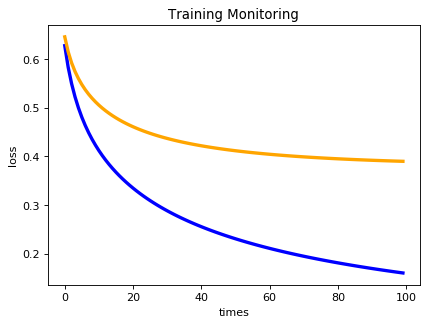

In [64]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4.3), dpi=80)
plt.title("Training Monitoring")
plt.xlabel("times")
plt.ylabel("loss")



plt.plot(loss_tr_count,color='blue',linewidth=3.0)
plt.plot(dev_loss_count,color='orange',linewidth=3.0)


plt.show()

Explain here...

Compute accuracy, precision, recall and F1-scores:

In [ ]:
Y_te=[]
for i in range(0,len(test_sets_list)):
     Y_te.append(test_sets_list[i][1])
test_vector=vectorise(test_ngram, vocab_train)
preds_te_count=predict_class(test_vector,w_count)

In [58]:

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.835
Precision: 0.8941176470588236
Recall: 0.76
F1-Score: 0.8216216216216216


Finally, print the top-10 words for the negative and positive class respectively.

In [105]:
type(w_count)

numpy.ndarray

In [130]:
# this function can return top-10 words for the negative and positive class
def top_words(w_list):
    w_sort_positive=sorted(w_list,reverse = True)
    w_positive_index=[]
    positive_list=[]
    for i in range(10):
        index=w_list.index(w_sort_positive[i])
        w_positive_index.append(index)
        positive_list.append(vocabulary[index])
        
    w_sort_negative=sorted(w_list)
    w_negative_index=[]
    negative_list=[]
    for i in range(10):
        index=w_list.index(w_sort_negative[i])
        w_negative_index.append(index)
        negative_list.append(vocabulary[index])    
    return positive_list,negative_list    

In [122]:
#print the top-10 words for the negative and positive class respectively
positive_list,negative_list=top_words(w_count.tolist())
print('positive_list:',positive_list)
print('negative_list:',negative_list)

positive_list: ['great', 'well', 'seen', 'fun', 'also', 'many', 'both', 'movies', 'life', 'see']
negative_list: ['bad', 'unfortunately', 'only', 'script', 'worst', 'boring', 'why', 'plot', 'any', 'nothing']


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Provide your answer here...

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [127]:
w_tfidf, trl, devl = SGD(train_vector_tfidf, Y_tr, 
                         X_dev=dev_vector_tfidf, 
                         Y_dev=Y_dev, 
                         lr=0.0001, 
                         alpha=0.00001, 
                         epochs=50)

epochs: 0 trainingloss: [[0.63885208]] validation_loss: [[0.66621195]]
epochs: 1 trainingloss: [[0.59679669]] validation_loss: [[0.64532873]]
epochs: 2 trainingloss: [[0.56221545]] validation_loss: [[0.62801918]]
epochs: 3 trainingloss: [[0.53301369]] validation_loss: [[0.61330603]]
epochs: 4 trainingloss: [[0.50786392]] validation_loss: [[0.6005835]]
epochs: 5 trainingloss: [[0.48586247]] validation_loss: [[0.58942992]]
epochs: 6 trainingloss: [[0.46636867]] validation_loss: [[0.57953825]]
epochs: 7 trainingloss: [[0.44891362]] validation_loss: [[0.57067882]]
epochs: 8 trainingloss: [[0.43314492]] validation_loss: [[0.56267628]]
epochs: 9 trainingloss: [[0.41879175]] validation_loss: [[0.55539438]]
epochs: 10 trainingloss: [[0.40564196]] validation_loss: [[0.54872561]]
epochs: 11 trainingloss: [[0.39352655]] validation_loss: [[0.54258389]]
epochs: 12 trainingloss: [[0.38230892]] validation_loss: [[0.53689949]]
epochs: 13 trainingloss: [[0.37187723]] validation_loss: [[0.5316152]]
epoc

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

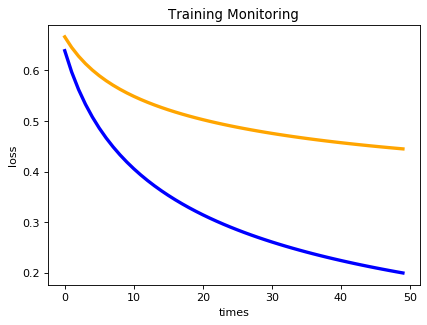

In [51]:
#plot the training and validation history per epoch
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4.3), dpi=80)
plt.title("Training Monitoring")
plt.xlabel("times")
plt.ylabel("loss")



plt.plot(trl,color='blue',linewidth=3.0)
plt.plot(devl,color='orange',linewidth=3.0)


plt.show()

Compute accuracy, precision, recall and F1-scores:

In [59]:

#Compute accuracy, precision, recall and F1-scores

preds_te_tfidf=predict_class(test_vector_tfidf,w_tfidf)


print('Accuracy:', accuracy_score(Y_te,preds_te_tfidf))
print('Precision:', precision_score(Y_te,preds_te_tfidf))
print('Recall:', recall_score(Y_te,preds_te_tfidf))
print('F1-Score:', f1_score(Y_te,preds_te_tfidf))

Accuracy: 0.825
Precision: 0.9276315789473685
Recall: 0.705
F1-Score: 0.8011363636363635




Print top-10 most positive and negative words:

In [131]:
# fill in your code...
positive_list,negative_list=top_words(w_tfidf.tolist())
print('positive_list:',positive_list)
print('negative_list:',negative_list)

positive_list: ['great', 'truman', 'life', 'perfectly', 'hilarious', 'terrific', 'perfect', 'memorable', 'excellent', 'world']
negative_list: ['bad', 'worst', 'boring', 'supposed', 'why', 'unfortunately', 'harry', 'stupid', 'ridiculous', 'nothing']


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

1  learning rate is 0.0001,because at this time, the curve drops most smoothly,But when the epochs is more than 20, the change of loss becomes very small.Regularisation strength is 2*weights*lr*alpha.This regularisation can mprove the precision of the model.
2 The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.
3 In my experiment, regularisation strength has little effect on the experimental results, but it does improve the precision of the model.This is because regularization avoids overfitting.



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |  0.894 | 0.760  |  0.821 |
| BOW-tfidf  | 0.927  | 0.705  | 0.801  |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [132]:
data_tr = pd.read_csv('data_topic/train.csv',header=-1)
data_dev = pd.read_csv('data_topic/dev.csv',header=-1)
data_test = pd.read_csv('data_topic/test.csv',header=-1)

In [133]:
data_tr.head()

,0,1
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [134]:
# fill in your code...

In [135]:
def get_rawX2(data):
    rawlist=[]
    for i in range(0,len(data)):
        rawlist.append(data[i][1])
       
    return rawlist#  a list of strings each corresponding to the raw text of a document

In [136]:
train2_list=data_tr.values.tolist()
development2_list=data_dev.values.tolist()
test2_list=data_test.values.tolist()

In [137]:
random.shuffle(train2_list)

In [138]:
train2_list_ngram=[]
for i in range(0,len(train2_list)): 
    a=extract_ngrams(train2_list[i][1], ngram_range=(1,3), stop_words=stop_words)
    train2_list_ngram.append(a)
development2_ngram=[]
for i in range(0,len(development2_list)): 
    a=extract_ngrams(development2_list[i][1], ngram_range=(1,3), stop_words=stop_words)
    development2_ngram.append(a)
test2_ngram=[]
for i in range(0,len(test2_list)): 
    a=extract_ngrams(test2_list[i][1], ngram_range=(1,3), stop_words=stop_words)
    test2_ngram.append(a)  

In [139]:
X_tr_raw2=get_rawX2(train2_list)
X_dev_raw2=get_rawX2(development2_list)
X_test_raw2=get_rawX2(test2_list)

In [140]:

vocab_train2, df_train2, ngram_counts_train2 = get_vocab(X_tr_raw2, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

In [141]:
train2_vector=vectorise(train2_list_ngram, vocab_train2)

In [142]:
dev2_vector=vectorise(development2_ngram, vocab_train2)

In [143]:
test2_vector=vectorise(test2_ngram, vocab_train2)

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [144]:
def softmax(z):

    smax=[]
    if z.ndim==1:
  
        smax = (np.exp(z))/(np.sum(np.exp(z)))
    else:
        smax = (np.exp(z))/(np.sum(np.exp(z),axis=1).reshape(-1,1))

    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [145]:
def predict_proba(X, weights):
  
    z=np.dot(X,weights.T) # x:1.5000   w:3.5000
   
    preds_proba=softmax(z)  #Output 3 possibilities per file
    
    
    return preds_proba  

In [146]:
def predict_class(X, weights):

    predict_class_=[]
    for i in range(0,len(X)):#Three possibilities per document
        preds_proba=predict_proba(X[i], weights) #Three possibilities
        
        preds_class=np.argmax(preds_proba)  #Add in the most likely one
        
        predict_class_.append(preds_class+1)
    return predict_class_

Toy example and expected functionality of the functions above:

In [147]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [148]:
predict_proba(X,w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [149]:
predict_class(X, w)

[2, 1, 1]

In [150]:
predict_class(X, w)

[2, 1, 1]

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [151]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    #  X  ： 2400*5000   w：3*5000


    preds_proba_list=predict_proba(X, weights) #2400 * 3
   
    predict=predict_class(X, weights)  # 2400*1
    
    weights=np.asarray(weights)
    loss_=[]

    for i in range(0,len(preds_proba_list)):
        l_=0  
        if predict[i]==Y[i]:
            if predict[i]==1:                
                l_=-np.log(preds_proba_list[i][0])*1 
            if predict[i]==2:
                l_=-np.log(preds_proba_list[i][1])*2     
            if predict[i]==3:
                l_=-np.log(preds_proba_list[i][2])*3 
        

        loss_.append(l_)

    l=sum(loss_)/X.shape[0]
    return l

Finally you need to modify SGD to support the categorical cross entropy loss:

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [152]:
#get Y list from train and dev data
Y2_tr=[]
for i in range(0,len(train2_list)):
    Y2_tr.append(train2_list[i][0])    
Y2_tr=np.asarray(Y2_tr)
Y2_tr=Y2_tr.reshape(Y2_tr.shape[0],1)
Y2_dev=[]
for i in range(0,len(development2_list)):
    Y2_dev.append(development2_list[i][0])   
Y2_dev=np.asarray(Y2_dev)
Y2_dev=Y2_dev.reshape(Y2_dev.shape[0],1)

In [153]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
    
    
    training_loss_history = []
    validation_loss_history = []
    weights=np.zeros(((3,len(X_tr[0]))))
    weights=np.asarray(weights)
    #get Y
    Y=np.zeros((len(Y_tr),3))
    for i in range(len(Y_tr)):
        if Y_tr[i]==1:
            Y[i][0]=1
        if Y_tr[i]==2:
            Y[i][1]=1
        if Y_tr[i]==3:
            Y[i][2]=1
    
    for j in range(0,epochs):
       
        for i in range(len(X_tr)):

            weights=weights-(lr*np.dot((predict_proba(X_tr[i],weights)-Y[i]).reshape(-1,1),X_tr[i].reshape(-1,1).T))-2*weights*lr*alpha
        #get train_loss
        train_loss=categorical_loss(X_tr,Y_tr, weights, alpha=0.00001)
        #get  validation_loss
        validation_loss=categorical_loss(X_dev, Y_dev, weights, alpha=0.00001)
       
        print('epochs:',j,'trainingloss:',train_loss,'validation_loss:',validation_loss)
        training_loss_history.append(train_loss)
        validation_loss_history.append(validation_loss)
     
        
    return weights, training_loss_history, validation_loss_history

In [154]:
w_count, loss_tr_count, dev_loss_count = SGD(train2_vector, Y2_tr, 
                                             X_dev=dev2_vector, 
                                             Y_dev=Y2_dev,
                                             num_classes=3,
                                             lr=0.01, 
                                             alpha=0.001, 
                                             epochs=200)

epochs: 0 trainingloss: 0.7482141895694419 validation_loss: 1.0625890937404094
epochs: 1 trainingloss: 0.5769173228381647 validation_loss: 0.8887030519527036
epochs: 2 trainingloss: 0.49663495347141046 validation_loss: 0.7890718306439675
epochs: 3 trainingloss: 0.4518054930479967 validation_loss: 0.7455031212224816
epochs: 4 trainingloss: 0.41905673378268865 validation_loss: 0.7212227585556968
epochs: 5 trainingloss: 0.3966244012011407 validation_loss: 0.6897170218329347
epochs: 6 trainingloss: 0.37900633419475405 validation_loss: 0.6516696953931818
epochs: 7 trainingloss: 0.36444217851916705 validation_loss: 0.6399383060127695
epochs: 8 trainingloss: 0.3530826302108728 validation_loss: 0.6255219306127877
epochs: 9 trainingloss: 0.34417194843244364 validation_loss: 0.6140112637186897
epochs: 10 trainingloss: 0.33531458904426864 validation_loss: 0.6047110781121825
epochs: 11 trainingloss: 0.32769092822685353 validation_loss: 0.5971265899160423
epochs: 12 trainingloss: 0.3220306873529473

epochs: 103 trainingloss: 0.28289594474791985 validation_loss: 0.521136471020725
epochs: 104 trainingloss: 0.28289289462685907 validation_loss: 0.5211383421178489
epochs: 105 trainingloss: 0.2828900377546541 validation_loss: 0.5211401206002131
epochs: 106 trainingloss: 0.28288736146192583 validation_loss: 0.5211418107226973
epochs: 107 trainingloss: 0.282884853942783 validation_loss: 0.521143416578278
epochs: 108 trainingloss: 0.2828825041933498 validation_loss: 0.5211449421004475
epochs: 109 trainingloss: 0.28288030195487834 validation_loss: 0.5211463910661107
epochs: 110 trainingloss: 0.2828782376611103 validation_loss: 0.5211477670988678
epochs: 111 trainingloss: 0.28287630238951567 validation_loss: 0.5211490736726124
epochs: 112 trainingloss: 0.2828744878161429 validation_loss: 0.5211503141153823
epochs: 113 trainingloss: 0.28287278617378114 validation_loss: 0.521151491613394
epochs: 114 trainingloss: 0.28287119021318385 validation_loss: 0.5211526092152323
epochs: 115 trainingloss:

Plot training and validation process and explain if your model overfit, underfit or is about right:

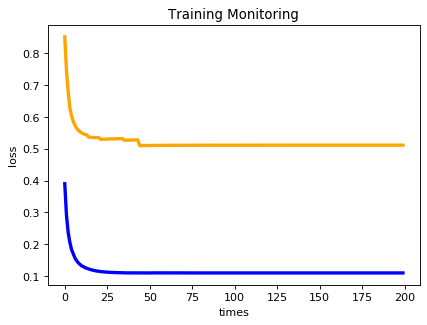

In [80]:
# Plot training and validation process 
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4.3), dpi=80)
plt.title("Training Monitoring")
plt.xlabel("times")
plt.ylabel("loss")



plt.plot(loss_tr_count,color='blue',linewidth=3.0)
plt.plot(dev_loss_count,color='orange',linewidth=3.0)


plt.show()

Compute accuracy, precision, recall and F1-scores:

In [66]:
Y_te=[]
for i in range(0,len(test2_list)):
     Y_te.append(test2_list[i][0])

preds_te=predict_class(test2_vector,w_count)

     

In [67]:
# fill in your code...

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8655555555555555
Precision: 0.8678678463011938
Recall: 0.8655555555555555
F1-Score: 0.8652497905147577


Print the top-10 words for each class respectively.

In [155]:
w_count.shape

(3, 5000)

In [159]:
# Print the top-10 words for each class respectively.

positive_list_World,negative_list_World=top_words(w_count[0].tolist())
positive_list_Sports,negative_list_Sports=top_words(w_count[1].tolist())
positive_list_Business,negative_list_Business=top_words(w_count[2].tolist())
print('class:World-positive:',positive_list_World)
print('class:Sports-positive:',positive_list_Sports)
print('class:Business-positive:',positive_list_Business)
print('class:World-negative:',negative_list_World)
print('class:Sports-negative:',negative_list_Sports)
print('class:Business-negative:',negative_list_Business)

class:World-positive: ['cover', 'captures', 'fancy', 'deeper', 'bus', 'williams', 'camera', 'process', 'will', 'learned']
class:Sports-positive: ['going', 'obvious', 'bastard', 'vehicle', 'justice', 'convincingly', 'sports', 'blues', 'hammer', 'paranoid']
class:Business-positive: [('but', 'if'), 'quest', 'older', 'saturday', 'cartoonish', 'gwyneth', 'scene', 'others', 'screaming', 'fincher']
class:World-negative: ['holiday', 'vehicle', ('but', 'if'), 'quest', 'justice', 'listen', 'melodrama', 'older', 'sports', 'saturday']
class:Sports-negative: ['camera', ('but', 'if'), 'captures', 'straight', 'holding', ('but', 'end'), ('not', 'mention'), ('end', 'film'), 'cover', 'deserved']
class:Business-negative: ['going', 'cover', 'obvious', 'bastard', 'learned', 'paranoid', 'ever', 'lake', 'gordon', 'yet']


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

1  learning rate is 0.01,because at this time, the curve drops most smoothly,But when the epochs is more than 20, the change of loss becomes very small.Regularisation strength is 2*weights*lr*alpha.This regularisation can mprove the precision of the model.
2 The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.
3 In my experiment, regularisation strength has little effect on the experimental results, but it does improve the precision of the model.This is because regularization avoids overfitting.

### Now evaluate BOW-tfidf...

## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |  0.867 | 0.865  | 0.865  |
| BOW-tfidf  | 0.861  | 0.861  |  0.860 |


In [69]:

vocab_train2, df_train2, ngram_counts_train2 = get_vocab(X_tr_raw2, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

vocab_dev2, df_dev2, ngram_counts_train2 = get_vocab(X_dev_raw2, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

vocab_test2, df_test2, ngram_counts_train2 = get_vocab(X_test_raw2, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

In [70]:
train2_vector=vectorise_tfidf(train2_list_ngram, vocab_train2,df_train2)
dev2_vector=vectorise_tfidf(development2_ngram, vocab_train2,df_dev2)
test2_vector=vectorise_tfidf(test2_ngram, vocab_train2,df_test2)


In [71]:
w_count, loss_tr_count, dev_loss_count = SGD(train2_vector, Y2_tr, 
                                             X_dev=dev2_vector, 
                                             Y_dev=Y2_dev,
                                             num_classes=3,
                                             lr=0.01, 
                                             alpha=0.001, 
                                             epochs=200)

epochs: 0 trainingloss: 0.39005644823112545 validation_loss: 0.8519649570469787
epochs: 1 trainingloss: 0.2917781828249325 validation_loss: 0.746619006001304
epochs: 2 trainingloss: 0.23710885481020477 validation_loss: 0.6799390253768253
epochs: 3 trainingloss: 0.20574031999521844 validation_loss: 0.6284960306048246
epochs: 4 trainingloss: 0.18286776647589045 validation_loss: 0.6031630947694815
epochs: 5 trainingloss: 0.16924828267413505 validation_loss: 0.5859120555147439
epochs: 6 trainingloss: 0.15654961101233986 validation_loss: 0.5736894335872155
epochs: 7 trainingloss: 0.14819519681879142 validation_loss: 0.564810932508113
epochs: 8 trainingloss: 0.1411014624692319 validation_loss: 0.5582598118863957
epochs: 9 trainingloss: 0.13623118335255116 validation_loss: 0.5533819347126507
epochs: 10 trainingloss: 0.1315426294445174 validation_loss: 0.5497360258916857
epochs: 11 trainingloss: 0.1292785333660281 validation_loss: 0.5470131781175466
epochs: 12 trainingloss: 0.1261127091564553 

epochs: 102 trainingloss: 0.10950265872798605 validation_loss: 0.5113226346090253
epochs: 103 trainingloss: 0.10950227329914078 validation_loss: 0.5113245832443059
epochs: 104 trainingloss: 0.10950191307557686 validation_loss: 0.5113264122500376
epochs: 105 trainingloss: 0.10950157633676184 validation_loss: 0.511328129092066
epochs: 106 trainingloss: 0.10950126148548603 validation_loss: 0.5113297407620429
epochs: 107 trainingloss: 0.10950096703852717 validation_loss: 0.511331253808087
epochs: 108 trainingloss: 0.10950069161806229 validation_loss: 0.5113326743634289
epochs: 109 trainingloss: 0.10950043394376832 validation_loss: 0.5113340081731755
epochs: 110 trainingloss: 0.10950019282555004 validation_loss: 0.511335260619322
epochs: 111 trainingloss: 0.10949996715684193 validation_loss: 0.5113364367441219
epochs: 112 trainingloss: 0.10949975590843797 validation_loss: 0.5113375412719275
epochs: 113 trainingloss: 0.10949955812280263 validation_loss: 0.5113385786296034
epochs: 114 trainin

In [72]:
Y_te=[]
for i in range(0,len(test2_list)):
     Y_te.append(test2_list[i][0])

preds_te=predict_class(test2_vector,w_count)

In [73]:
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8611111111111112
Precision: 0.861561205905335
Recall: 0.8611111111111112
F1-Score: 0.8605779327317181
